This notebook takes the geojson files written by createTrainingData.ipynb, and processes the contents into numpy arrays. The processed data are then used to fine-tune the VGG16 model that has already been pre-trained on ImageNet data.

Uncomment and run these first 3 cells at the start of every session

In [ ]:
"""
!pip install -q condacolab
import condacolab
condacolab.install()
"""

In [ ]:
"""
import condacolab
condacolab.check()
"""

In [ ]:
#!conda install pyogrio geopandas=0.14.3

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import geopandas as gpd
import pyarrow
import scipy.ndimage
from sklearn.model_selection import train_test_split

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# createTrainingData.ipynb created geojson files containing an ID number, geometry,
# and RGB reflectances for each Sentinel pixel in the areas around each farm or
# random building. We will reprocess them into individual pngs, one for each farm
# or random building area.

# Start by reading pig farm (label 1) and not-pig-farm (label 0) data into gdfs

gdf_1 = gpd.read_file('/content/drive/MyDrive/GEE_data/sentinelPigFarms.geojson')
gdf_0 = gpd.read_file('/content/drive/MyDrive/GEE_data/sentinelRandomBuildings.geojson')


Processing farm data
Displaying image 219


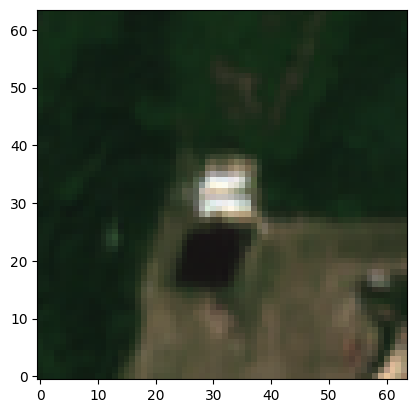

Displaying image 479


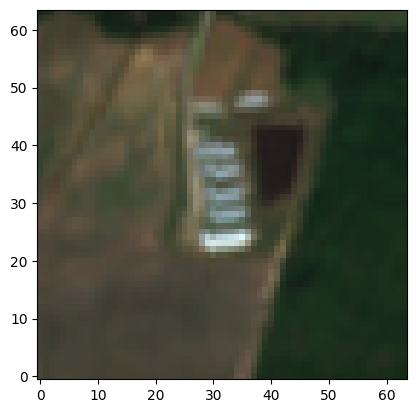

Displaying image 571


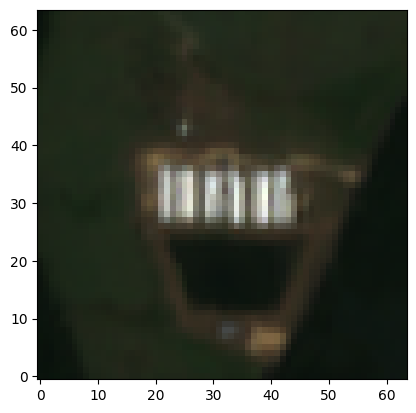

Displaying image 58


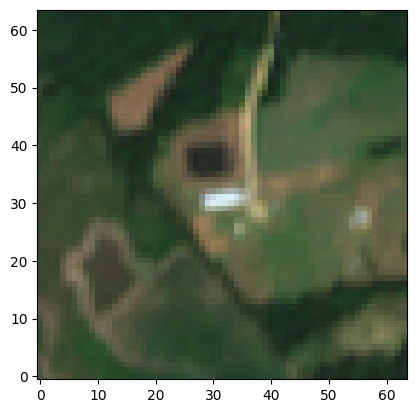

Displaying image 593


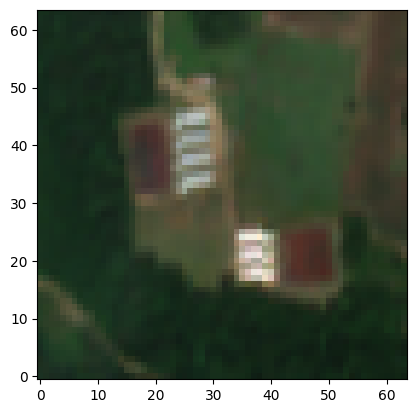

Started with 633 farms/not-farms
Rejected 6 images with irregular shapes
Wrote 627 images to Drive

Processing not-farm data
Displaying image 01b4000000000002728e


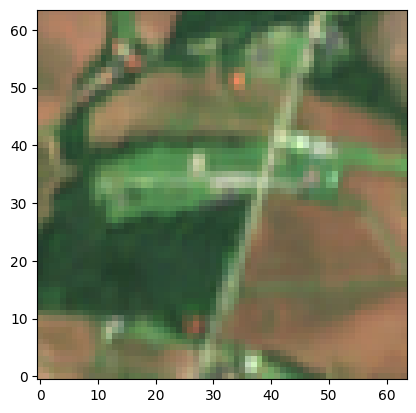

Displaying image 01b40000000000028ea7


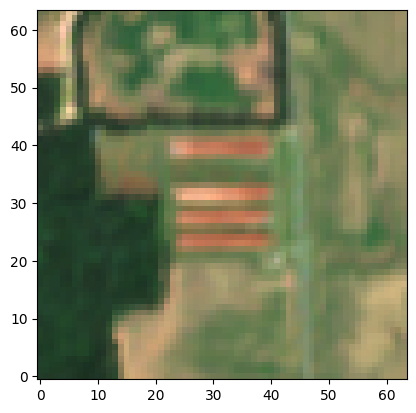

Displaying image 01b400000000000394fc


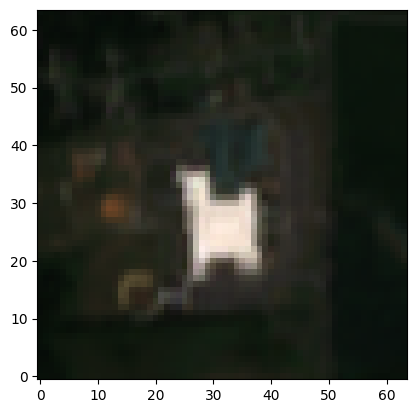

Displaying image 01b4000000000003a2fb


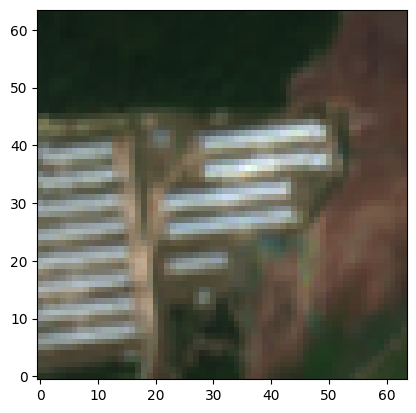

Displaying image 01b4000000000003c9d2


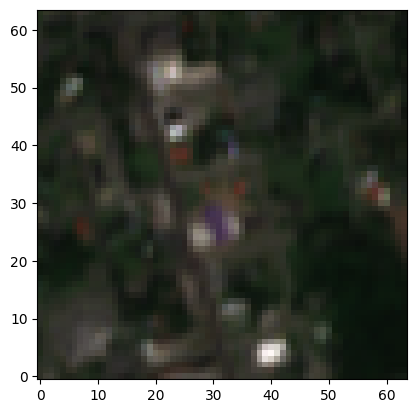

Started with 643 farms/not-farms
Rejected 11 images with irregular shapes
Wrote 632 images to Drive


In [6]:
# Convert those dataframes into a 4D numpy array (samples, height, width, channels)
# Some steps here are specific to VGG16:
#   - The channels are in order BGR (not RGB)
#   - The data have been rescaled to 0-255 and the ImageNet mean values subtracted
# As these steps have already performed, the modeling shouldn't call
# keras.applications.vgg16.preprocess_input()

def process_for_vgg16(gdf, show=None):

    # Remove suffixes from pixel ID numbers so we can group all pixels for a
    # given farm or not-farm
    # E.g, 1_1, 1_2, 1_3, 1_4 --> 1, 1, 1, 1

    gdf['id'] = gdf['id'].str.split('_').str[0]

    rejected = 0
    arr_list = []
    groups = gdf.groupby(by='id')

    # Here, a group will be an individual farm or not-farm
    for n, group in groups:
      data = {'B2': [], 'B3': [], 'B4': []}
      _ = group.groupby(by=group.geometry.y)

      # Gather the group's pixels into a 3D array
      for coord, vals in _:
        for band in ['B2', 'B3', 'B4']:
          data[band].append([b for b in vals[band]])
      try:
        arr = np.stack([np.array(data['B2']), np.array(data['B3']), np.array(data['B4'])])
      except ValueError as e:
        # These are presumably groups that intersect with the boundary of the region
        # They cause problems because they aren't rectangular; might able to pad but
        # that seems like more trouble than it's worth
        rejected += 1
        continue

      # Move the channels axis to the end
      arr = np.moveaxis(arr, [0], [2])

      # Resize the images to 64 x 64 pix
      arr = scipy.ndimage.zoom(
          arr,
          (64/arr.shape[0], 64/arr.shape[1], 1),
          mode='reflect'
          )

      # Rescale to 0-255 (using max over all bands)
      arr = (arr / np.max(arr)) * 255

      # Optionally, display a few images as a sanity check
      if show is not None and n in show:
        print(f"Displaying image {n}")
        # Reverse channels (BGR --> RGB) and rotate 90 deg to match GEE Map
        plt.imshow(arr[:,:,::-1].astype(int), vmin=0, vmax=255, origin="lower")
        plt.show()

      # Subtract ImageNet mean values per band. Obtained from chatGPT, confirmed here:
      # stackoverflow.com/questions/46622428/what-is-the-expected-input-range-for-working-with-keras-vgg-models
      means = np.array([103.94, 116.78, 123.68])
      arr = arr - means

      # The image is ready now, so add it to the list
      arr_list.append(arr)

    # Final 4D array containing all images
    dataset = np.array(arr_list)

    print(f"Started with {len(groups)} farms/not-farms")
    print(f"Rejected {rejected} images with irregular shapes")
    print(f'Wrote {dataset.shape[0]} images to Drive')

    return dataset


def sample_to_display(gdf, n=5):
  return [s.split('_')[0] for s in gdf['id'].sample(n).to_list()]

print('Processing farm data')
show = sample_to_display(gdf_1)
images_cat1 = process_for_vgg16(gdf_1, show=show)

print('\nProcessing not-farm data')
show = sample_to_display(gdf_0)
images_cat0 = process_for_vgg16(gdf_0, show=show)

In [7]:
# Create training, validation, and test datasets from those two image arrays


# Combine all the farm and not-farm images into a single array
images = np.concatenate([images_cat1, images_cat0], axis=0)

# Create an array of image labels
labels_cat1 = np.ones(len(images_cat1))
labels_cat0 = np.zeros(len(images_cat0))
labels = np.concatenate([labels_cat1, labels_cat0], axis=0)

# Randomly shuffle images and labels in unison
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

# Split into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, labels, test_size=0.10, random_state=42)  # 10% for testing

# Split training + validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.22, random_state=42)  # ~20% for validation


In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
# Load VGG-16 pre-trained on ImageNet data, exclude the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(64, 64, 3)))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = Flatten()(base_model.output)  # Flatten the output of the base layers

# Add dense layers
x = Dense(256, activation='relu')(x)  # A dense layer with 256 units and ReLU activation
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting

# Output layer for binary classification
output = Dense(1, activation='sigmoid')(x)  # Sigmoid activation for binary probability

# Create the new model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Data augmentation and generator setup
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Fit the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=10  # Adjust the number of epochs based on your specific needs
)

Epoch 1/10
28/28 [==============================] - 65s 2s/step - loss: 0.6556 - accuracy: 0.6274 - val_loss: 0.4913 - val_accuracy: 0.7600
Epoch 2/10
28/28 [==============================] - 60s 2s/step - loss: 0.4667 - accuracy: 0.7746 - val_loss: 0.4537 - val_accuracy: 0.7800
Epoch 3/10
28/28 [==============================] - 64s 2s/step - loss: 0.4117 - accuracy: 0.8097 - val_loss: 0.4203 - val_accuracy: 0.8000
Epoch 4/10
28/28 [==============================] - 64s 2s/step - loss: 0.3931 - accuracy: 0.8335 - val_loss: 0.4547 - val_accuracy: 0.7800
Epoch 5/10
28/28 [==============================] - 56s 2s/step - loss: 0.3416 - accuracy: 0.8550 - val_loss: 0.4151 - val_accuracy: 0.8040
Epoch 6/10
28/28 [==============================] - 69s 2s/step - loss: 0.3378 - accuracy: 0.8607 - val_loss: 0.4137 - val_accuracy: 0.8120
Epoch 7/10
28/28 [==============================] - 56s 2s/step - loss: 0.2884 - accuracy: 0.8856 - val_loss: 0.3851 - val_accuracy: 0.8280
Epoch 8/10
28/28 [==

In [18]:
# Fine-tune the model

# Unfreeze some of the base model layers
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model (necessary after making layer trainable changes)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Continue training
history_fine = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=5  # Fewer epochs as you're fine-tuning
)

Epoch 1/5
28/28 [==============================] - 83s 3s/step - loss: 6.5329 - accuracy: 0.5277 - val_loss: 0.6209 - val_accuracy: 0.7320
Epoch 2/5
28/28 [==============================] - 79s 3s/step - loss: 0.5817 - accuracy: 0.7055 - val_loss: 0.3752 - val_accuracy: 0.8520
Epoch 3/5
28/28 [==============================] - 80s 3s/step - loss: 0.4256 - accuracy: 0.8063 - val_loss: 0.3187 - val_accuracy: 0.8720
Epoch 4/5
28/28 [==============================] - 81s 3s/step - loss: 0.3060 - accuracy: 0.8732 - val_loss: 0.3587 - val_accuracy: 0.8240
Epoch 5/5
28/28 [==============================] - 81s 3s/step - loss: 0.2745 - accuracy: 0.8924 - val_loss: 0.5826 - val_accuracy: 0.7560
